In [32]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score,root_mean_squared_error
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv(r'..\Data\Delivery_data.csv')

In [4]:
df

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,distance,time,Weather,time of day
0,37,4.9,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,5.241,24,Sunny,Morning
1,34,4.5,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,29.365,33,Stormy,Evening
2,23,4.4,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,5.483,26,Sandstorms,Morning
3,38,4.7,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,11.917,21,Sunny,Evening
4,32,4.6,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,12.974,30,Cloudy,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25129,32,4.8,conditions Cloudy,Low,1,Buffet,scooter,1,No,Urban,21.542,30,Cloudy,Night
25130,29,4.5,conditions Fog,Low,2,Meal,electric_scooter,0,No,Metropolitian,11.366,11,Fog,Night
25131,22,4.7,conditions Stormy,Jam,0,Snack,motorcycle,1,No,Metropolitian,14.187,27,Stormy,Evening
25132,38,4.7,conditions Sandstorms,Medium,0,Snack,motorcycle,1,No,Urban,9.364,28,Sandstorms,Afternoon


In [18]:
print(df['Delivery_person_Ratings'].value_counts())

Delivery_person_Ratings
4.8    4063
4.9    4059
4.7    4037
4.6    4017
5.0    2296
4.5    1919
4.1     858
4.2     838
4.3     833
4.4     824
4.0     636
3.5     151
3.8     126
3.6     120
3.7     114
3.9     111
3.2      22
3.1      18
3.3      17
3.4      15
2.6      13
2.5      12
2.7      12
2.8      11
2.9       9
3.0       3
Name: count, dtype: int64


<Axes: >

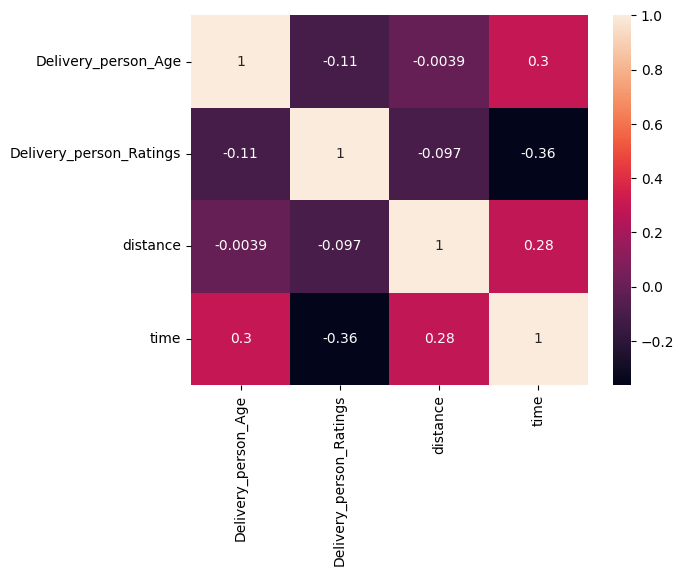

In [31]:
numerical_columns=['Delivery_person_Age','Delivery_person_Ratings','distance','time']
sns.heatmap(df[numerical_columns].corr(),annot=True)


In [ ]:
numerical_columns=['Delivery_person_Age','Delivery_person_Ratings','distance']
cat_cols=['Type_of_vehicle','Weather','Road_traffic_density','multiple_deliveries','Festival','City','time of day','Vehicle_condition'] 
X_train,X_test,y_train,y_test=train_test_split(df[numerical_columns+cat_cols],df['time'],test_size=0.2)

In [7]:
preprocessor=ColumnTransformer([
    ('numerical',StandardScaler(),numerical_columns),
    ('categorical',OneHotEncoder(),cat_cols)
],remainder='passthrough')
pipeline=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('regressor',XGBRegressor(random_state=42,n_jobs=-1))
])

In [8]:
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)
print(f"Test score: {r2_score(y_test,y_pred)}")
print(f"Train score: {pipeline.score(X_train,y_train)}")
print(f"Test RMSE: {root_mean_squared_error(y_test,y_pred)}")

Test score: 0.7938072085380554
Train score: 0.8665894269943237
Test RMSE: 4.201701077164398


## Model 1 - XGBRegressor

In [ ]:
def objective(params):
    model = XGBRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        n_jobs=-1
    )
    pipeline=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('regressor',model)
    ])


    pipeline.fit(X_train, y_train)
    y_pred=pipeline.predict(X_test)
    score = r2_score(y_test,y_pred)

    return {'loss': -score, 'status': STATUS_OK}

param_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
}

In [10]:
trials = Trials()
best_params = fmin(
    fn=objective,
    space=param_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(42)
)

100%|██████████| 50/50 [01:37<00:00,  1.95s/trial, best loss: -0.8096404075622559]


In [11]:
best_params

{'colsample_bytree': 0.8549159812217342,
 'gamma': 1.8956721422754617,
 'learning_rate': 0.03873623447073392,
 'max_depth': 8.0,
 'n_estimators': 517.0,
 'reg_alpha': 1.379336120117143,
 'reg_lambda': 1.5403826119087305,
 'subsample': 0.9985191526976377}

In [12]:
best_params['max_depth']=int(best_params['max_depth'])
best_params['n_estimators']=int(best_params['n_estimators'])
pipeline=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('regressor',XGBRegressor(**best_params,random_state=42,n_jobs=-1))
])
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)
print(f"Test score: {r2_score(y_test,y_pred)}")
print(f"Train score: {pipeline.score(X_train,y_train)}")
print(f"Test RMSE: {root_mean_squared_error(y_test,y_pred)}")

Test score: 0.8087986707687378
Train score: 0.8671997785568237
Test RMSE: 4.046074323197995


In [14]:
with open(r'../model/model.pkl','wb') as f:
    pickle.dump(pipeline,f)

## Model 2

In [ ]:

def objective(params):
    model = XGBRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        n_jobs=-1
    )
    pipeline=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('regressor',model)
    ])


    pipeline.fit(X_train, y_train)
    y_pred=pipeline.predict(X_test)
    score = r2_score(y_test,y_pred)
    return {'loss': -score, 'status': STATUS_OK}

param_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
}
trials1 = Trials()
best_params = fmin(
    fn=objective,
    space=param_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials1,
    rstate=np.random.default_rng(42)
)

100%|██████████| 100/100 [05:05<00:00,  3.05s/trial, best loss: -0.8113396763801575]


In [16]:
best_params

{'colsample_bytree': 0.7704201113920344,
 'gamma': 1.0677358157972023,
 'learning_rate': 0.011064665226464989,
 'max_depth': 9.0,
 'n_estimators': 654.0,
 'reg_alpha': 0.9406867902759138,
 'reg_lambda': 4.477853980972736,
 'subsample': 0.8454028232579619}

In [17]:
best_params['max_depth']=int(best_params['max_depth'])
best_params['n_estimators']=int(best_params['n_estimators'])
pipeline=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('regressor',XGBRegressor(**best_params,random_state=42,n_jobs=-1))
])
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)
print(f"Test score: {r2_score(y_test,y_pred)}")
print(f"Train score: {pipeline.score(X_train,y_train)}")
print(f"Test RMSE: {root_mean_squared_error(y_test,y_pred)}")

Test score: 0.8116288185119629
Train score: 0.8625956773757935
Test RMSE: 4.016017734554056


In [21]:
with open(r'../model/model2.pkl','wb') as f:
    pickle.dump(pipeline,f)

## Model 2: RandomForest Regressor

In [ ]:
def objective_(params):
    rf_model = RandomForestRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features'],
        random_state=42,
        n_jobs=-1
    )
    rf_pipeline=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('regressor',rf_model)
    ])

    rf_pipeline.fit(X_train, y_train)
    y_pred=rf_pipeline.predict(X_test)
    score = r2_score(y_test,y_pred)

    return {'loss': -score, 'status': STATUS_OK}

param_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),  
    'max_depth': scope.int(hp.quniform('max_depth', 5, 30, 1)),           
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1), 
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),    
    'max_features': hp.choice('max_features', ['sqrt', 'log2']) 
}

In [23]:
trials2 = Trials()
best_params = fmin(
    fn=objective_,
    space=param_space,
    algo=tpe.suggest,
    max_evals=100, 
    trials=trials2,
    rstate=np.random.default_rng(42)
)

100%|██████████| 100/100 [04:19<00:00,  2.60s/trial, best loss: -0.7998361574842783]


## Using an extra columns

In [ ]:
numerical_columns=['Delivery_person_Age','Delivery_person_Ratings','distance']
cat_cols=['Type_of_vehicle','Weather','Road_traffic_density','multiple_deliveries','Festival','City','time of day'] 
X_train,X_test,y_train,y_test=train_test_split(df[numerical_columns+cat_cols],df['time'],test_size=0.2)

In [ ]:
preprocessor=ColumnTransformer([
    ('numerical',StandardScaler(),numerical_columns),
    ('categorical',OneHotEncoder(),cat_cols)
],remainder='passthrough')

def objective(params):
    model = XGBRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        n_jobs=-1
    )
    pipeline=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('regressor',model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred=pipeline.predict(X_test)
    score = r2_score(y_test,y_pred)

    return {'loss': -score, 'status': STATUS_OK}

param_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
}
trials3 = Trials()
best_params = fmin(
    fn=objective,
    space=param_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials3,
    rstate=np.random.default_rng(42)
)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [05:19<00:00,  3.19s/trial, best loss: -0.7598671913146973]


## Testing LinearRegression

In [ ]:
numerical_columns=['Delivery_person_Age','Delivery_person_Ratings','distance']
cat_cols=['Type_of_vehicle','Weather','Road_traffic_density','multiple_deliveries','Festival','City','time of day','Vehicle_condition'] 
X_train,X_test,y_train,y_test=train_test_split(df[numerical_columns+cat_cols],df['time'],test_size=0.2)
preprocessor=ColumnTransformer([
    ('numerical',StandardScaler(),numerical_columns),
    ('categorical',OneHotEncoder(),cat_cols)
],remainder='passthrough')
pipeline=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('regressor',LinearRegression(n_jobs=-1))
])
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)
print(f"Test score: {r2_score(y_test,y_pred)}")
print(f"Train score: {pipeline.score(X_train,y_train)}")
print(f"Test RMSE: {root_mean_squared_error(y_test,y_pred)}")

Test score: 0.597254080409384
Train score: 0.6031941111911703
Test RMSE: 5.90597015528961
